In [280]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak

def findAllPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2))
    
#    print(sum(data[:,1] == 0))  # if this was 217 => n=108
# n is the number of zeros/2 (but that is not the final count..)
# output is index ranges: each peak starts and ends with a zero
# so that there are two zeros between each peak

    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0

    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])  # notice '='
#    print(last)  = 106
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
#    print(len(indices))   # why now 107?
# OK, if you have only one zero, then it is not a separation mark for peaks 
    return indices

# Essentially same as JKo 4.3.

In [155]:
#import numpy as np
#import pandas as pd
#
#def readFile(fileName):
#    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

# New 4.3.

In [256]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])  # painotettu keskiarvo
    sigma = (mu/280000)/(2*np.log(2))
    
#    sigma = (mu/280000)/(2*math.sqrt(2*np.log(2)))               # is the same as above
#    fitfunc = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2) # is the same as below

    fitfunc  = lambda p, x: p[0]*np.exp(-((x-p[1])/(2*sigma))**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c[1]

# Still same as 4.3. JKo ( #-lines above give the same result )

In [281]:
import numpy as np

def getAllMeans(peaks,indices):
#    indices = findAllPeakIndices(peaks)
    n = len(indices)  

    means = np.zeros(n)
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        means[i] = getMean(peak)
    return means

# JKo 4.3. modified by KOj 8.3.

In [258]:
import numpy as np
import math

def getAreas(peak):
    sum = np.sum(peak[:,1])
    width = peak[len(peak)-1,0]-peak[0,0]
#    print(sum)
#    print(width)
    return sum*width

# KO 8.3.

In [309]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):
#def getAllAreas(data, peaklist, identified):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getAreas(peak)

    return areas

# KO 8.3.

In [332]:
import pandas as pd
import numpy as np

def identifyPeaks(data, peakMeans, peakAreas, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peaklist['area'] = np.zeros(len(peaklist['mz']))  

    trueValue = peaklist['mz'].to_numpy()     # grab only mz values from the peaklist
#    print("len trueV ",len(trueValue))
#    print("len areas ",len(peakAreas))
#    print("len means ",len(peakMeans))
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
     
# np.argmin: Returns the indices of the minimum values along an axis.   

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: observed is 0, because never got a new value

    newpeaklist = peaklist.drop(unidentified)
    print("Number of final peaks: ",len(newpeaklist))
    print(newpeaklist)
    return newpeaklist

# New 4.3.  modified by KO 8.3.

In [339]:
# Method to read in one spectrum
# A large number of averaged, denoised spectra are exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print("File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")  # possible that 'sep' is not necessary here

    print("Shape: {}, {}".format(*df.shape))
    print()
    print()
#print(df.iloc[0:3,:2])# Zero works here
    data = df.iloc[0:,:2].to_numpy().astype("float64")

#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKoli's
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64") JKo

    return(data)
# New 4.3. was modified 8.3. by KO


File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-28.csv
Shape: 1672, 2


Number of final peaks:  76
         formula          mz    observed   peak           area
1           O3N-   61.988366   61.988376    5.0  113563.785121
2       O3N[15]-   62.985401   62.985418    9.0      20.549758
3      O2O[17]N-   62.992584   62.992607   10.0       4.222421
4      O2O[18]N-   63.992613   63.992662   11.0      42.458007
8        C4H5O2-   85.029503   85.029585   14.0       0.191558
..           ...         ...         ...    ...            ...
262  C14H16O5NF-  297.101799  297.101801   96.0      14.117933
269  C10H14O10N-  308.062319  308.062228   98.0       5.219511
274  C10H16O10N-  310.077969  310.077775   99.0       0.778989
279  C11H16O10N-  322.077969  322.078011  100.0       5.699218
282  C10H14O11N-  324.057234  324.057105  101.0       6.999349

[76 rows x 5 columns]


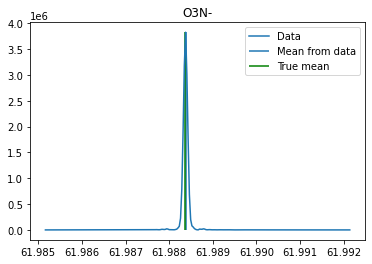

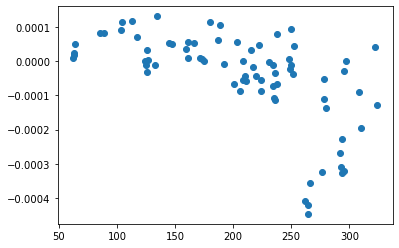

Above: (observed mz > true mz) as a function of true mz


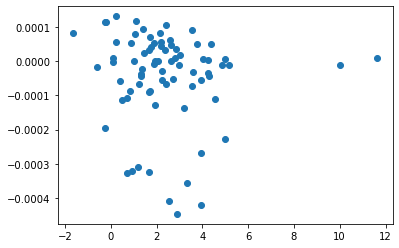

Above: (observed mz > true mz) as a function of log(peak area)


In [345]:
# Plot a peak etc.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = readSpectrum(2)    # Read the nth file in the folder of spectra
peakindices = findAllPeakIndices(data)
peakMeans = getAllMeans(data,peakindices)
peakAreas = getAllAreas(data,peakindices)

#peaklist = pd.read_csv("peaklist.csv")             # JKo
#peaklist = identifyPeaks(data, peaklist, 0.002)    # JKo

ionFileName = "C:/Users/kojal/pyharj/DSpro/Allions1ex.csv"
peaklist = identifyPeaks(data, peakMeans, peakAreas, pd.read_csv(ionFileName, sep=","), 0.002)

# Choose peak   ( i:th peak from the left, i starts from zero)
i = 0
ii = int(peaklist.iloc[i,3])
peak = data[peakindices[ii,0]:peakindices[ii,1]+1]

plt.plot(peak[:,0],peak[:,1])
plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
plt.legend(["Data","Mean from data","True mean"])
plt.title(peaklist.iloc[i,0])
plt.show()

xmz = peaklist.iloc[:,1]
ydiff = peaklist.iloc[:,2]-peaklist.iloc[:,1]
plt.scatter(xmz,ydiff)
plt.show()
print("Above: (observed mz > true mz) as a function of true mz")

ylogarea = np.log(peaklist.iloc[:,4])
plt.scatter(ylogarea,ydiff)
plt.show()
print("Above: (observed mz > true mz) as a function of log(peak area)")
# JKO 4.3. modified by KOj 8.3.

In [342]:
print("")

In [104]:
# example
